## Sanity Checks

This is a little notebook with some sanity checks.
Proper tests are in [tests/](./tests/).
This notebook is just to visually look at how the simulation behaves.
Note, there might be some extra libraries used here, which are not mentioned anywhere else.

In [1]:
from itertools import product, combinations
import math
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import torch
from plotnine import *
import magicsoup as ms
from magicsoup.constants import GAS_CONSTANT
from magicsoup.examples.wood_ljungdahl import MOLECULES, REACTIONS, co2, formiat, formylFH4, NADPH, NADP, methylenFH4

theme_set(theme_minimal())
CHEMISTRY = ms.Chemistry(molecules=MOLECULES, reactions=REACTIONS)

### Genome Sizes

I would expect overall more coding regions (CDSs) and thus more proteins in larger genomes.
However, the likelihood of encountering a stop codon (in-frame) should stay the same.
So, the average CDS length and thus the expected number of domains per protein should not grow with larger genomes.

In [2]:
genetics = ms.Genetics(chemistry=CHEMISTRY)
records = []
for size in (100, 200, 300, 400, 500, 1000):
    for _ in range(1000):
        genome = ms.random_genome(s=size)
        proteins = genetics.get_proteome(seq=genome)
        records.append({
            "size": size,
            "n": len(proteins),
            "v": "proteins/genome"
        })
        if len(proteins) > 0:
            records.append({
                "size": size,
                "n": sum(len(d.domains) for d in proteins) / len(proteins),
                "v": "domains/protein"
            })
df = pd.DataFrame.from_records(records)

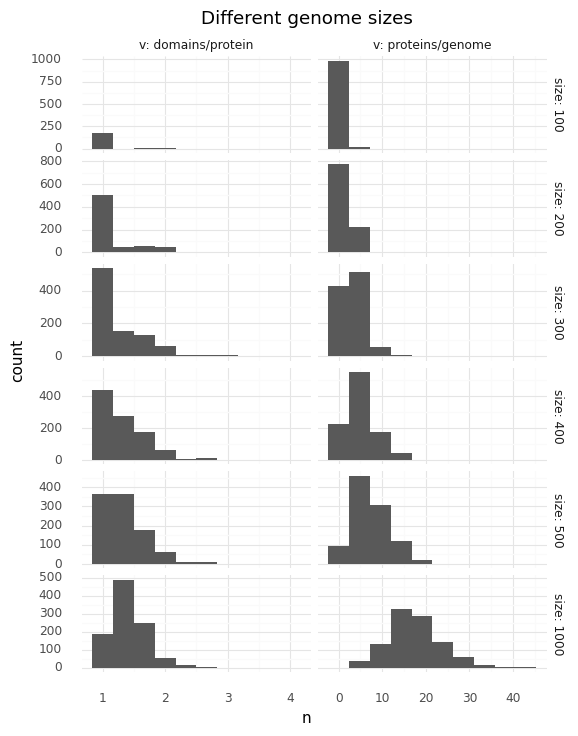

<ggplot: (8758472364535)>

In [3]:
(ggplot(df)
    + geom_histogram(aes(x="n"), bins=10)
    + facet_grid("size ~ v", scales="free", labeller="label_both")
    + theme(figure_size=(6, 8))
    + ggtitle("Different genome sizes"))

### Molecule Diffusion and Degradation

Below, I just want to see on a small map whether diffusion and degradation looks correct (_e.g._ using the circular map).
The diffusion coefficients and half lifes are what I would expect to be realistic values.
It would also be nice to see that differences in diffusion with different diffusion coefficients, and differences in degradation with different half lifes
actually make a visible difference.

In [4]:
ma = ms.Molecule("A", 10, diff_coef=1e-6, half_life=100_000)
mb = ms.Molecule("B", 10, diff_coef=1e-7, half_life=10_000)
mc = ms.Molecule("C", 10, diff_coef=1e-8, half_life=1_000)
molecules = [ma, mb, mc]

chemistry = ms.Chemistry(molecules=molecules, reactions=[])
world = ms.World(chemistry=chemistry, map_size=9, mol_map_init="zeros")
world.molecule_map[:, 4, 4] = 10.0
world.molecule_map[:, 5, 5] = 10.0
world.molecule_map[:, 8, 8] = 10.0

records = []
for si in range(10):
    for mi, mol in enumerate(molecules):
        for x, y in product(range(9), range(9)):
            records.append({
                "step": si,
                "mol": mol.name,
                "x": x,
                "y": y,
                "c": world.molecule_map[mi, x, y].item()
            })
    world.diffuse_molecules()
    world.degrade_molecules()
df = pd.DataFrame.from_records(records)

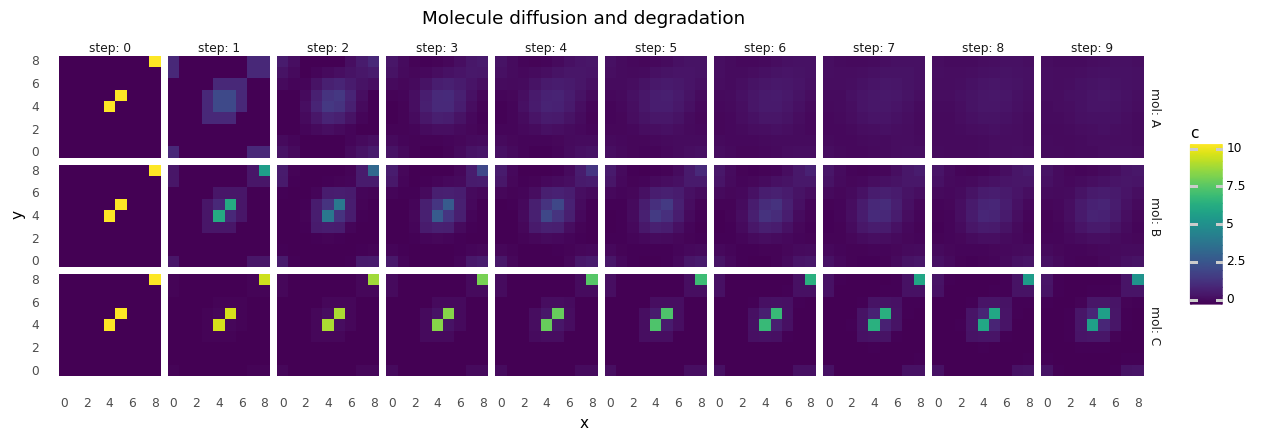

<ggplot: (8758472752122)>

In [5]:
(ggplot(df)
    + geom_tile(aes(x="x", y="y", fill="c"))
    + facet_grid("mol ~ step", labeller="label_both")
    + coord_equal(expand=False)
    + theme(figure_size=(14, 6))
    + ggtitle("Molecule diffusion and degradation"))

## Equilibrium Constants

Any reaction always moved into the direction of lowering Gibb's free energy $\Delta G = \Delta G_0 + RT \ln Q$.
This term is influenced by the internal energy difference of the reaction's substrates and products $\Delta G_0$, and by the change in entropy which can be expressed as a function of the reaction quotient $R \ln Q$.
At equilibrium these 2 terms cancel each other out $\Delta G_0 = RT \ln K_e$.
Thus, looking at the equilibrium constants $K_e$ of this simulation is good to see how favourable certain reactions are, or how much concentration gradients will influence the reaction.

For reactions such as $NADPH \rightleftharpoons NADP^- + H^+$ I expect large $K_e$. However, the majority of $K_e$ should not be too far away from 1.0.
Otherwise, cells could not make any use of concentration gradients to gain energy.
Below, I look at each defined reaction separately.
Then, I am also looking at what reactions are catalyzed by proteins from random genomes.

In [6]:
world = ms.World(chemistry=CHEMISTRY)

records = []
for subs, prods in REACTIONS:
    name = " + ".join(str(d) for d in subs) + " <-> " + " + ".join(str(d) for d in prods)
    energy = sum(d.energy for d in prods) - sum(d.energy for d in subs)
    ke = math.exp(-energy / (GAS_CONSTANT * world.abs_temp))
    records.append({"name": name, "Ke": ke})

genomes = [ms.random_genome(s=300) for _ in range(100)]
world.add_random_cells(genomes=genomes)
for cell in world.cells:
    for protein in cell.proteome:
        energy = 0.0
        for dom in protein.domains:
            if dom.is_catalytic:
                energy -= sum(d.energy for d in dom.substrates)
                energy += sum(d.energy for d in dom.products)
        ke = math.exp(-energy / (GAS_CONSTANT * world.abs_temp))
        records.append({"name": "random proteins", "Ke": ke})

df = pd.DataFrame.from_records(records)

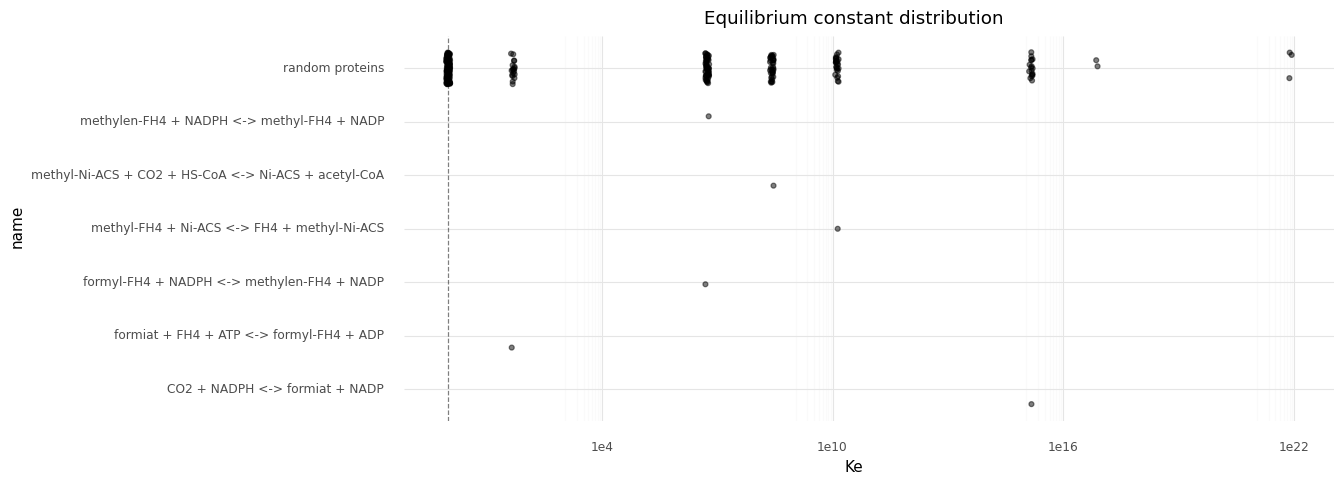

<ggplot: (8758471943927)>

In [7]:
(ggplot(df, aes(x="name", y="Ke"))
    + geom_hline(yintercept=1.0, linetype="dashed", alpha=.5)
    + geom_jitter(data=df, alpha=.5, width=.3, height=.05)
    + scale_y_log10()
    + coord_flip()
    + theme(figure_size=(12, 5))
    + ggtitle("Equilibrium constant distribution"))

### Working Cell

Below I want to see how a cell actually starts to work and change its environment.
I currently don't have a clever way of defining a cell other than just assigning a genome.
So, the resulting cell is completely random.

First, a plot showing how the cell changes its environment over time.
Molecules suffixed with `[i]` are the intracellular molecule species, ones suffixed with `[e]` are the extracellular one
(on the pixel the cell lives on).

Second, networks depicting this cell's proteome.
To reduce the clutter I am plotting each protein one by one as a single network, instead of showing all proteins as a single network.
The protein itself is always the gray middle node with its size being proportional to $V_{Max}$.
Arrows point to and from substrates/products and effectors.
Substrates and product arrows are gray, inhibiting effectors are red, activating effectors are green.
Arrow widths are proportional to $K_M^{-1}$.
Intracellular molecules are blue, extracellular ones orange.

In [8]:
world = ms.World(chemistry=CHEMISTRY)
world.molecule_map *= 100
while True:
    world.add_random_cells(genomes=[ms.random_genome(s=300)])
    if len(world.cells[0].proteome) >= 10:
        break
    world.kill_cells(cell_idxs=[0])

cell = world.cells[0]
for protein in cell.proteome:
    print(f"{protein}: {', '.join(str(d) for d in protein.domains)}")

P0: TransporterDomain(HS-CoA,inwards)
P1: TransporterDomain(HS-CoA,inwards)
P2: TransporterDomain(formyl-FH4,inwards)
P3: TransporterDomain(formyl-FH4,inwards)
P4: TransporterDomain(HS-CoA,inwards)
P5: TransporterDomain(NADPH,outwards)
P6: CatalyticDomain(formyl-FH4,NADPH->NADP,methylen-FH4), TransporterDomain(formyl-FH4,inwards)
P7: TransporterDomain(HS-CoA,inwards)
P8: TransporterDomain(NADPH,outwards)
P9: TransporterDomain(formyl-FH4,inwards)
P10: CatalyticDomain(formyl-FH4,NADPH->NADP,methylen-FH4), TransporterDomain(formyl-FH4,inwards)


In [9]:
records = []
for si in range(40):
    for mol in MOLECULES:
        records.append({
            "step": si,
            "molecule": f"{mol.name}[i]",
            "c": world.cell_molecules[0, mol.idx].item()
        })
        records.append({
            "step": si,
            "molecule": f"{mol.name}[e]",
            "c": world.molecule_map[mol.idx, cell.position[0], cell.position[1]].item()
        })
    world.enzymatic_activity()
    world.degrade_molecules()
    world.diffuse_molecules()
df = pd.DataFrame.from_records(records)

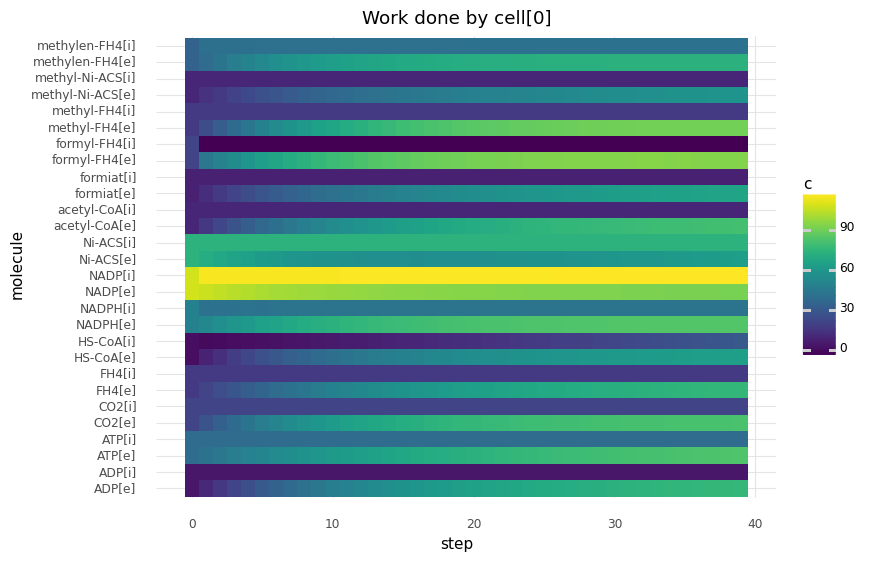

<ggplot: (8758472306496)>

In [10]:
(ggplot(df)
    + geom_tile(aes(x="step", y="molecule", fill="c"))
    + theme(figure_size=(8, 6))
    + ggtitle(f"Work done by cell[{cell.idx}]"))

In [11]:
graphs = []
for pi, protein in enumerate(cell.proteome):
    vs = []
    G = nx.DiGraph()
    for dom in protein.domains:
        kwargs = {
            "w": abs(1 / math.log(1 + dom.affinity)),
            "c": "gray"
        }
        if dom.is_catalytic:
            vs.append(dom.velocity)
            suffix = "[e]" if dom.is_transmembrane else "[i]"
            for mol in dom.substrates:
                G.add_edge(f"{mol.name}{suffix}", "", **kwargs)
            for mol in dom.products:
                G.add_edge("", f"{mol.name}{suffix}", **kwargs)
        if dom.is_transporter:
            vs.append(dom.velocity)
            mol = dom.substrates[0]
            G.add_edge(f"{mol.name}[i]", "", **kwargs)
            G.add_edge("", f"{mol.name}[e]", **kwargs)
        if dom.is_regulatory:
            kwargs["c"] = "r" if dom.is_inhibiting else "g"
            suffix = "[e]" if dom.is_transmembrane else "[i]"
            G.add_edge(f"{mol.name}{suffix}", "", **kwargs)
    
    for key, val in G.nodes.items():
        if key == "":
            val["s"] = sum(vs) / len(vs) if len(vs) > 0 else 1e-2
            val["c"] = "gray"
        else:
            val["s"] = 1e-1
            val["c"] = "orange" if key.endswith("[e]") else "blue"
        val["s"] = math.log(1 + val["s"])

    graphs.append(G)

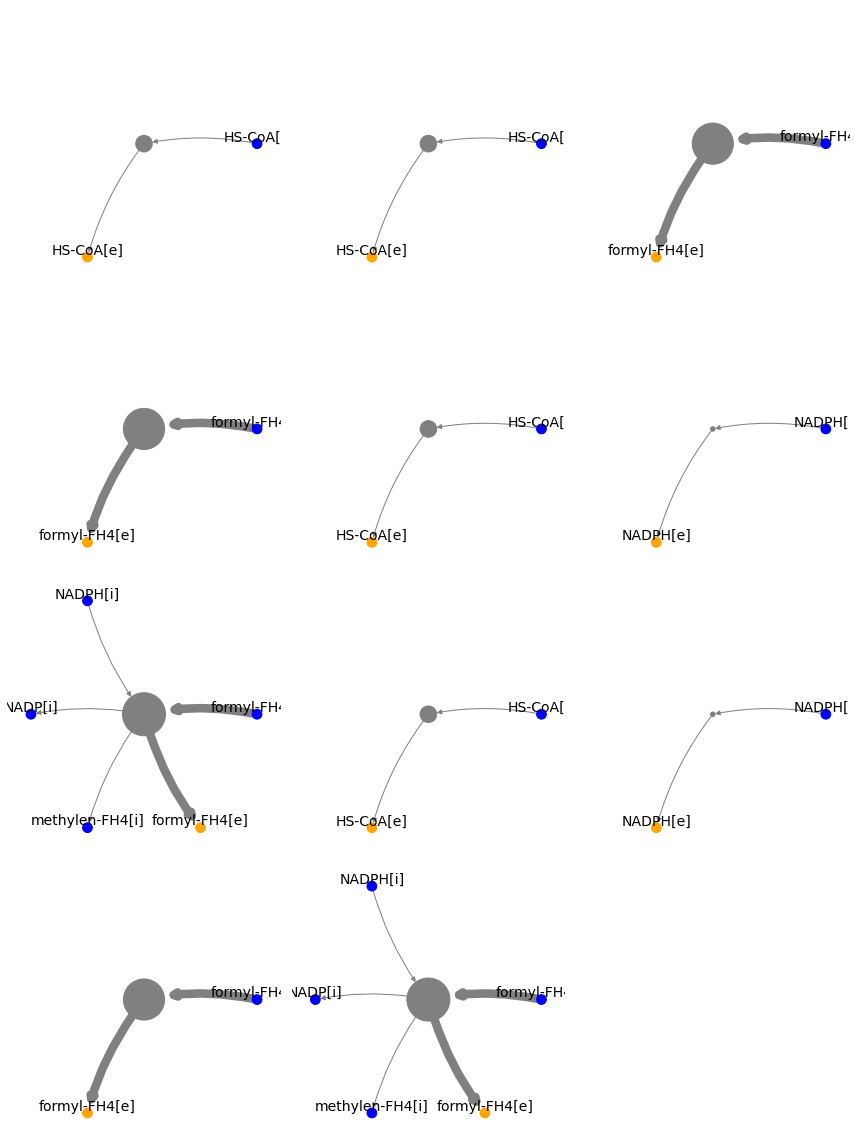

In [12]:
n_cols = 3
n_rows = int(math.ceil(len(graphs) / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(n_cols * 4, n_rows * 4))

for plot_i, ax in enumerate(axs.flat):
    ax.axis("off")
    
    if plot_i < len(graphs):
        G = graphs[plot_i]
    
        pos = nx.circular_layout(G, center=(0, 0))
        pos[""] = (0, 0)
        
        edgewidths = [G.get_edge_data(u, v)["w"] * 1e-4 + 1 for u, v in G.edges()]
        nodesizes = [v["s"] * 1e3 for v in G.nodes.values()]
        edgecols = [G.get_edge_data(u, v)["c"] for u, v in G.edges()]
        nodecols = [v["c"] for v in G.nodes.values()]

        nx.draw(
            G, pos, ax=ax,
            node_size=nodesizes,
            node_color=nodecols,
            width=edgewidths,
            edge_color=edgecols,
            connectionstyle="arc3,rad=0.1",
            
        )

        nx.draw_networkx_labels(G, pos, ax=ax, font_size=14, verticalalignment="bottom")
        ax.margins(0.1, 0.05)

fig.tight_layout()
plt.show()

## Free Energy in Simulation

Cells can make use of the internal energy of molecules and concentration differences of molecules to drive reactions.
While doing that, and while molecules are allowed to diffuse, the overall available free Gibb's energy of the world decreases.
So, even without degrading molecules, without regular energy supply cells will eventually all die.

I want to see how entropy $\Delta S$, internal energy $\Delta U$, and Gibb's free energy $\Delta G$ evolve over time.
Calculating internal energy is straight forward as I can just count all molecule energies at any point in time.
With the system's overall entropy, I am not sure.
Since the energy term of this simulation is based on the Nernst equiation with reaction quotient $Q$, I am deriving a value for entropy from $Q$ as well.
First, I am considering that any molecule species in the molecule map can diffuse from one place to another $S_{diff} = f(Q, \delta x, \delta y)$.
For the molecule map all Moore's neighbordhoods of every pixel have to be considered. 
Secondly, a molecule species can be converted into another molecule species in the cell $S_{mol} = f(Q, \delta Molecule)$.
Cells can also transport molecule in and out of the cell which basically equates to converting this molecule species from its intracellular to its extracellular version.
These entropies are log summed and adjusted to [J/mol].

The plot below looks at the situation with molecule diffusion only, with enzymatic activity only, and with diffusion and enzymatic activity.
Interestingly, with enzymatic activity only $\Delta U$ first increases a little bit before decreasing.
I think this was due to reactions that moved against $\Delta U$ because of their reaction quotient $Q$.
Then, after a few rounds, these reactions cease and only reactions that decrease $\Delta U$ continue.
Also, $\Delta S$ decreases a little bit when no diffusion is allowed.
I'm assuming that when no diffusion is allowed cells can ammass molecules on their pixels without them being able to diffuse into the map.
Thus there would be large $Q$ created around these pixels.

In [13]:
def init_world() -> ms.World:
    molecules = [co2, formiat, formylFH4, methylenFH4, NADPH, NADP]
    reactions = [
        ([co2, NADPH], [formiat, NADP]),
        ([formylFH4, NADPH], [methylenFH4, NADP]),
    ]
    chemistry = ms.Chemistry(molecules=molecules, reactions=reactions)
    world = ms.World(chemistry=chemistry)
    world.molecule_map = (world.molecule_map + 1.0) * 2.0
    world.add_random_cells(genomes=[ms.random_genome(s=300) for _ in range(1000)])
    return world

def energy(t: torch.Tensor, mols: list[ms.Molecule]) -> float:
    return sum(t[d.idx].sum().item() * d.energy for d in mols)

def world_energy(world: ms.World) -> float:
    u1 = energy(t=world.molecule_map, mols=world.genetics.chemistry.molecules)
    u2 = energy(t=world.cell_molecules.T, mols=world.genetics.chemistry.molecules)
    return u1 + u2

def quotient(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    s = torch.max(torch.stack([a / b, b / a]), dim=0).values
    return s[s.isfinite()]

def diffusion_entropy(mm: torch.Tensor) -> float:
    m = mm.clone()
    m = torch.cat([m[:, [-1]], m, m[:, [0]]], dim=1)
    m = torch.cat([m[:, :, [-1]], m, m[:, :, [0]]], dim=2)
    ew = quotient(m[:, 1:, 1:-1], m[:, :-1, 1:-1])
    ns = quotient(m[:, 1:-1, 1:], m[:, 1:-1, :-1])
    ne = quotient(m[:, 1:, 1:], m[:, :-1, :-1])
    se = quotient(m[:, 1:, :-1], m[:, :-1, 1:])
    q = torch.cat([ew.flatten(), ns.flatten(), ne.flatten(), se.flatten()])
    return -torch.sum(torch.log(q)).item() * GAS_CONSTANT

def mol_entropy(cm: torch.Tensor, mm: torch.Tensor, pos: list[tuple[int, int]]) -> float:
    sums = []
    xs, ys = list(map(list, zip(*pos)))
    X = torch.cat([cm, mm[:, xs, ys].T], dim=1)
    for a, b in combinations(range(X.size(1)), 2):
        q = quotient(X[:, a], X[:, b])
        sums.append(torch.sum(torch.log(q)).item())
    for a, b in combinations(range(mm.size(0)), 2):
        q = quotient(mm[a], mm[b])
        sums.append(torch.sum(torch.log(q)).item())
    return -sum(sums) * GAS_CONSTANT

def world_entropy(world: ms.World) -> float:
    s1 = diffusion_entropy(mm=world.molecule_map)
    s2 = mol_entropy(mm=world.molecule_map, cm=world.cell_molecules, pos=[d.position for d in world.cells])
    return s1 + s2

records = []
n_steps = 100

world = init_world()
U0 = world_energy(world)
S0 = world_entropy(world)
for step_i in range(n_steps):
    world.diffuse_molecules()
    records.append({
        "label": "diffusion",
        "step": step_i,
        "dU": U0 - world_energy(world),
        "dS": world_entropy(world) - S0,
    })

world = init_world()
U0 = world_energy(world)
S0 = world_entropy(world)
for step_i in range(n_steps):
    world.enzymatic_activity()
    records.append({
        "label": "enzymatic-activity",
        "step": step_i,
        "dU": U0 - world_energy(world),
        "dS": world_entropy(world) - S0,
    })

world = init_world()
U0 = world_energy(world)
S0 = world_entropy(world)
for step_i in range(n_steps):
    world.enzymatic_activity()
    world.diffuse_molecules()
    records.append({
        "label": "both",
        "step": step_i,
        "dU": U0 - world_energy(world),
        "dS": world_entropy(world) - S0,
    })

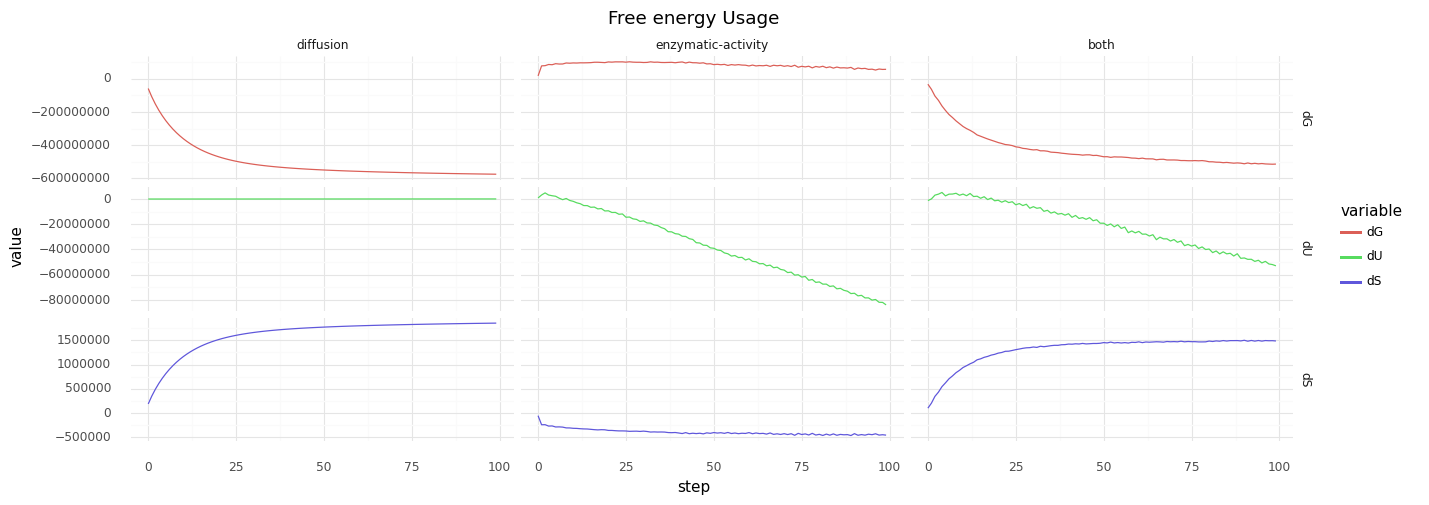

<ggplot: (8758453913167)>

In [14]:
df = pd.DataFrame.from_records(records)
df["dG"] = df["dU"] - df["dS"] * world.abs_temp
df = df.melt(id_vars=["step", "label"], value_vars=["dG", "dU", "dS"])
df["variable"] = pd.Categorical(df["variable"], categories=["dG", "dU", "dS"])
df["label"] = pd.Categorical(df["label"], categories=["diffusion", "enzymatic-activity", "both"])

(ggplot(df)
    + geom_line(aes(x="step", y="value", color="variable"))
    + theme(figure_size=(15, 5))
    + facet_grid("variable ~ label", scales="free")
    + ggtitle("Free energy Usage"))